In [1]:
import pandas as pd
import numpy as np
import nltk
from collections import Counter
from nltk.corpus import stopwords
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.optimize import minimize
stops = set(stopwords.words("english"))
import xgboost as xgb
from sklearn.cross_validation import train_test_split
import multiprocessing
import difflib

train = pd.read_csv('../input/train.csv')[:1000]
test = pd.read_csv('../input/test.csv')[:1000]

tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 1))
#cvect = CountVectorizer(stop_words='english', ngram_range=(1, 1))

tfidf_txt = pd.Series(train['question1'].tolist() + train['question2'].tolist() + test['question1'].tolist() + test['question2'].tolist()).astype(str)
tfidf.fit_transform(tfidf_txt)
#cvect.fit_transform(tfidf_txt)

/home/takaya/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<4000x6109 sparse matrix of type '<class 'numpy.float64'>'
	with 20315 stored elements in Compressed Sparse Row format>

In [2]:
from nltk import FreqDist
words = []
for s in tfidf_txt:
    words.extend(s.lower().split())
freq = FreqDist(words)

In [3]:
import gensim
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

model = gensim.models.KeyedVectors.load_word2vec_format('../data/GoogleNews-vectors-negative300.bin.gz', binary=True)

2017-03-30 04:12:50,295 : INFO : loading projection weights from ../data/GoogleNews-vectors-negative300.bin.gz
2017-03-30 04:15:34,892 : INFO : loaded (3000000, 300) matrix from ../data/GoogleNews-vectors-negative300.bin.gz


In [5]:
def diff_ratios(st1, st2):
    seq = difflib.SequenceMatcher()
    seq.set_seqs(str(st1).lower(), str(st2).lower())
    return seq.ratio()

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

tfidf_index = {w: i for i, w in enumerate(tfidf.get_feature_names())}
def get_idf(word):
    return tfidf.idf_[tfidf_index[word]]

def word_match_share_idf(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops and word in tfidf_index:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops and word in tfidf_index:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    shared_words_in_q1 = sum(get_idf(w) for w in q1words.keys() if w in q2words)
    shared_words_in_q2 = sum(get_idf(w) for w in q2words.keys() if w in q1words)
    qq1 = sum(get_idf(w) for w in q1words.keys())
    qq2 = sum(get_idf(w) for w in q2words.keys())
    return (shared_words_in_q1 + shared_words_in_q2) / (qq1 + qq2)


def top_idf_in_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops and word in tfidf_index:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops and word in tfidf_index:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    
    return max((get_idf(w) for w in q1words.keys() if w in q2words), default=0)

def filter_stopwords(s):
    return [w for w in str(s).lower().split() if w not in stops]

def filter_stopwords_tok(s):
    return [w for w in nltk.word_tokenize(str(s).lower()) if w not in stops]

def n_sim(row):
    w1 = [w for w in row['q1_tok_words'] if w in model]
    w2 = [w for w in row['q2_tok_words'] if w in model]
    if w1 and w2:
        # s
        return model.n_similarity(w1, w2)
    else:
        return 0


def get_features(df_features):      
    print('nouns...')
    df_features['question1_nouns'] = df_features.question1.map(lambda x: [w for w, t in nltk.pos_tag(nltk.word_tokenize(str(x).lower())) if t[:1] in ['N']])
    df_features['question2_nouns'] = df_features.question2.map(lambda x: [w for w, t in nltk.pos_tag(nltk.word_tokenize(str(x).lower())) if t[:1] in ['N']])
    df_features['z_noun_match'] = df_features.apply(lambda r: sum([1 for w in r.question1_nouns if w in r.question2_nouns]), axis=1)  #takes long
    print('lengths...')
    df_features['z_len1'] = df_features.question1.map(lambda x: len(str(x)))
    df_features['z_len2'] = df_features.question2.map(lambda x: len(str(x)))
    df_features['z_word_len1'] = df_features.question1.map(lambda x: len(str(x).split()))
    df_features['z_word_len2'] = df_features.question2.map(lambda x: len(str(x).split()))
    print('difflib...')
    df_features['z_match_ratio'] = df_features.apply(lambda r: diff_ratios(r.question1, r.question2), axis=1)  #takes long
    print('word match...')
    df_features['z_word_match'] = df_features.apply(word_match_share, axis=1, raw=True)
    
    print('word match_idf...')
    df_features['z_word_match_idf'] = df_features.apply(word_match_share_idf, axis=1, raw=True)

    
    print('top_idf_in_share')
    df_features['z_top_idf_in_share'] = df_features.apply(top_idf_in_share, axis=1, raw=True)
    
    print('tfidf...')
    q1_tfidf = df_features.question1.map(lambda x: tfidf.transform([str(x)]).data)
    q2_tfidf = df_features.question2.map(lambda x: tfidf.transform([str(x)]).data)
    
    df_features['z_tfidf_sum1'] = q1_tfidf.map(lambda x: np.sum(x))
    df_features['z_tfidf_sum2'] = q2_tfidf.map(lambda x: np.sum(x))
    df_features['z_tfidf_mean1'] = q1_tfidf.map(lambda x: np.mean(x))
    df_features['z_tfidf_mean2'] = q2_tfidf.map(lambda x: np.mean(x))
    df_features['z_tfidf_len1'] = q1_tfidf.map(lambda x: len(x))
    df_features['z_tfidf_len2'] = q2_tfidf.map(lambda x: len(x))
    
    print('word2vec...')
    df_features['q1_tok_words'] = df_features.question1.apply(filter_stopwords_tok)
    df_features['q2_tok_words'] = df_features.question2.apply(filter_stopwords_tok)
    df_features['z_n_sim'] = df_features.apply(n_sim, axis=1)


    return df_features.fillna(0.0)

#featured_train = get_features(train)
#train.to_csv('train.csv', index=False)

In [9]:
word_match_share({'question1': "What ethnicity were the Moors of Sicily?", 'question2': "Who were the moors?"})

0.0

In [101]:
col = [c for c in featured_train.columns if c[:1] == 'z']

def balance_data_size(x, y):
    x_pos = x[y == 1]
    x_neg = x[y == 0]
    y_pos = y[y == 1]
    y_neg = y[y == 0]
    
    p = 0.165
    while len(x_pos) / (len(x_pos) + len(x_neg)) > p:
        x_neg = pd.concat([x_neg, x_neg])
        y_neg = pd.concat([y_neg, y_neg])
    need_negs = int((1 - p) / p * len(x_pos))
    x_neg = x_neg[:need_negs]
    y_neg = y_neg[:need_negs]
  
    x = pd.concat([x_pos, x_neg])
    y = pd.concat([y_pos, y_neg])
    return (x, y)

def balance_data_ori(x_train, y_train):
    pos_train = x_train[y_train == 1]
    neg_train = x_train[y_train == 0]

    # Now we oversample the negative class
    # There is likely a much more elegant way to do this...
    p = 0.165
    scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
    while scale > 1:
        neg_train = pd.concat([neg_train, neg_train])
        scale -=1
    neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
    print(len(pos_train) / (len(pos_train) + len(neg_train)))

    x_train = pd.concat([pos_train, neg_train])
    y_train = (np.zeros(len(pos_train)) + 1).tolist() + np.zeros(len(neg_train)).tolist()
    return (x_train, y_train)

#featured_train_x, featured_train_y = balance_data_ori(featured_train[col], featured_train['is_duplicate'])
featured_train_x, featured_train_y = balance_data_ori(rest[col], rest['is_duplicate'])

x_train, x_valid, y_train, y_valid = train_test_split(featured_train_x, featured_train_y, test_size=0.2, random_state=0)

# (x_train, y_train) = balance_data_size(x_train, y_train)
# (x_valid, y_valid) = balance_data_size(x_valid, y_valid)
print(sum(y_train) / len(y_train))

0.19124366100096607
0.19123846070071815


In [6]:
test = get_features(test)
#test.to_csv('test.csv', index=False)

nouns...
lengths...
difflib...
word match...
word match_idf...
tfidf...


/home/takaya/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/takaya/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


word2vec...


In [102]:
params = {}
params["objective"] = "binary:logistic"
params['eval_metric'] = 'logloss'
params["eta"] = 0.02
params["subsample"] = 0.7
params["min_child_weight"] = 1
params["colsample_bytree"] = 0.7
params["max_depth"] = 6
params["silent"] = 1
params["seed"] = 87978979

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgb.train(params, d_train, 2000, watchlist, early_stopping_rounds=50, verbose_eval=100) #change to higher #s

[0]	train-logloss:0.683488	valid-logloss:0.683525
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.377299	valid-logloss:0.379496
[200]	train-logloss:0.345387	valid-logloss:0.348713
[300]	train-logloss:0.337696	valid-logloss:0.341882
[400]	train-logloss:0.333036	valid-logloss:0.337992
[500]	train-logloss:0.329594	valid-logloss:0.335333
[600]	train-logloss:0.32684	valid-logloss:0.333309
[700]	train-logloss:0.324155	valid-logloss:0.331422
[800]	train-logloss:0.321918	valid-logloss:0.329914
[900]	train-logloss:0.320015	valid-logloss:0.328674
[1000]	train-logloss:0.31817	valid-logloss:0.327455
[1100]	train-logloss:0.316429	valid-logloss:0.326336
[1200]	train-logloss:0.314907	valid-logloss:0.325405
[1300]	train-logloss:0.31341	valid-logloss:0.324436
[1400]	train-logloss:0.311945	valid-logloss:0.323528
[1500]	train-logloss:0.310514	valid-logloss:0.322656
[1600]	train-log

KeyboardInterrupt: 

In [8]:
def balance_data_size2(train):
    pos = train[train['is_duplicate'] == 1]
    neg = train[train['is_duplicate'] == 0]
    p = 0.165
    while len(pos) / (len(pos) + len(neg)) > p:
        neg = pd.concat([neg, neg])
    need_negs = int((1 - p) / p * len(pos))
    neg = neg[:need_negs]

    return pd.concat([pos, neg])

balanced_train = balance_data_size2(train)

In [21]:
log_loss(balanced_train.is_duplicate, bst.predict(xgb.DMatrix(balanced_train[col])))

0.28784689108395217

In [22]:
sub = pd.DataFrame()
sub['test_id'] = test['test_id']
sub['is_duplicate'] = bst.predict(xgb.DMatrix(test[col]))

sub.to_csv('result.csv', index=False)

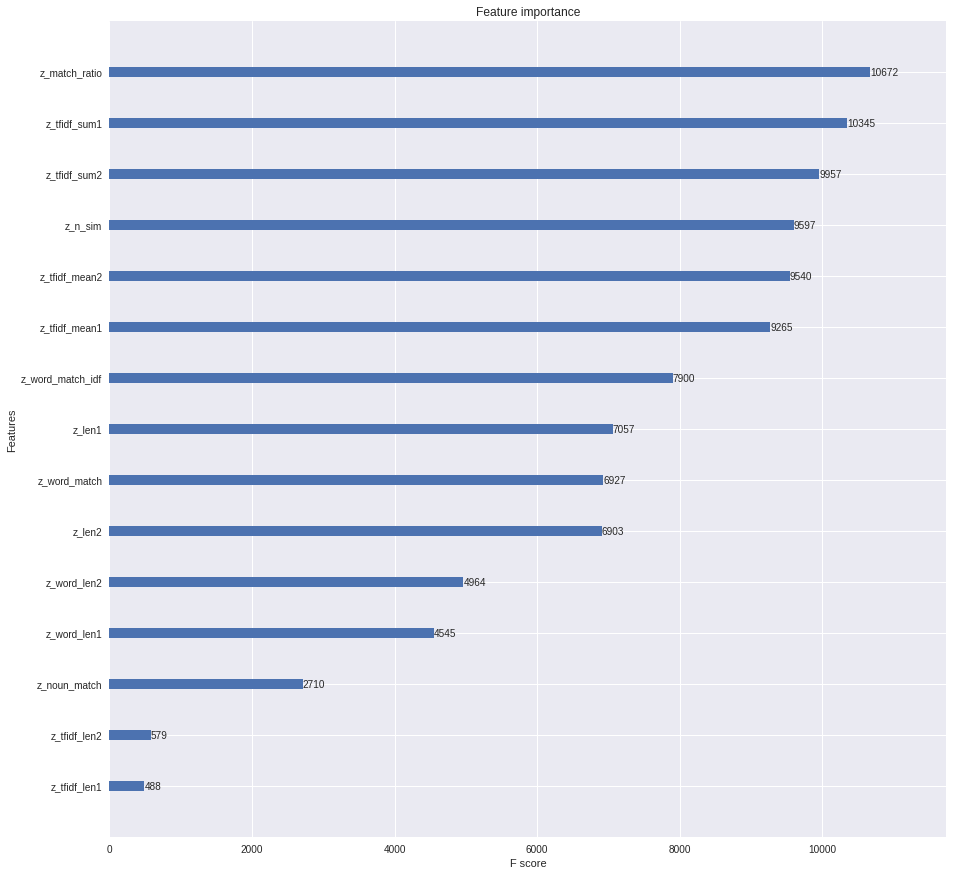

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (15.0, 15.0)
xgb.plot_importance(bst); plt.show()

In [12]:
# plt.rcParams['figure.figsize'] = (50.0, 50.0)
# xgb.plot_tree(bst, num_trees=0); plt.show()

In [13]:
train.to_csv('train_df.csv')
test.to_csv('test_df.csv')

(array([  2.89619395e-02,   2.18823543e-03,   5.92110764e-03,
          9.26782065e-03,   1.00401390e-02,   1.20996547e-02,
          1.58325269e-02,   2.40705898e-02,   3.66851234e-02,
          8.01923926e-02,   1.53948799e-01,   2.89748115e-01,
          5.30711452e-01,   9.50852655e-01,   1.56072674e+00,
          2.38968181e+00,   3.11128463e+00,   3.37181336e+00,
          3.19958636e+00,   3.42947980e+00]),
 array([-0.0409568 ,  0.01109104,  0.06313888,  0.11518672,  0.16723456,
         0.2192824 ,  0.27133024,  0.32337808,  0.37542592,  0.42747376,
         0.4795216 ,  0.53156944,  0.58361728,  0.63566512,  0.68771296,
         0.7397608 ,  0.79180864,  0.84385648,  0.89590432,  0.94795216,  1.        ]),
 <a list of 20 Patch objects>)

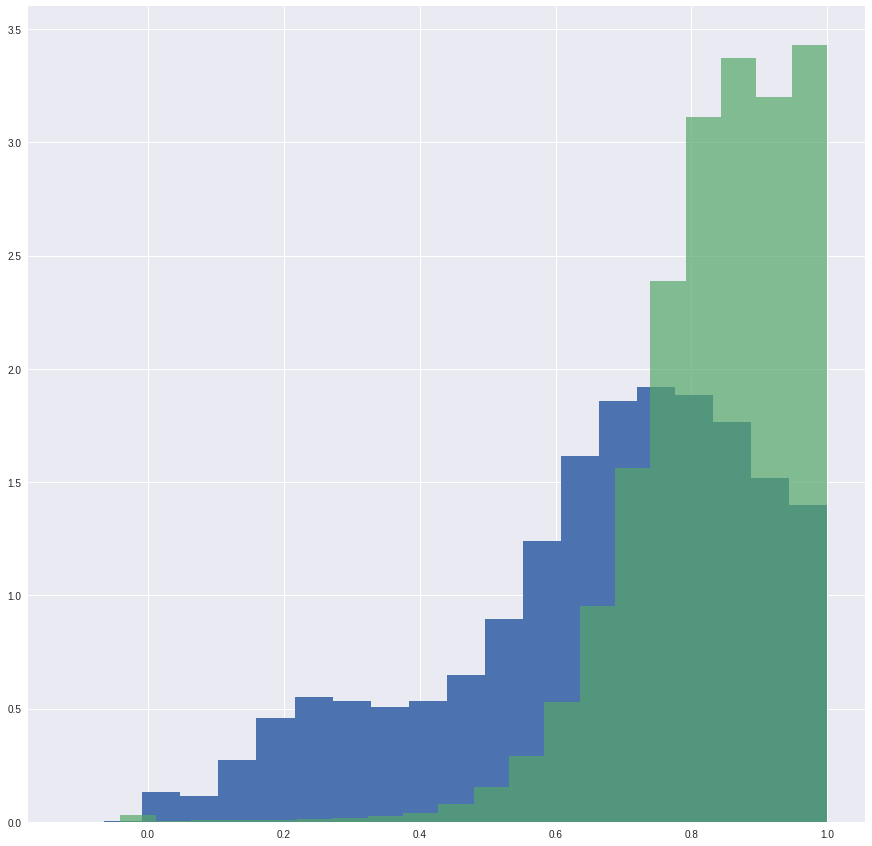

In [24]:
plt.hist(featured_train.z_n_sim[featured_train['is_duplicate'] == 0], bins=20, normed=True, label='0')
plt.hist(featured_train.z_n_sim[featured_train['is_duplicate'] == 1], bins=20, normed=True, label='1', alpha=0.7)

(array([  1.36671513e-02,   0.00000000e+00,   1.47390847e-03,
          7.77151739e-03,   1.22334403e-01,   3.66601234e-01,
          1.56944454e+00,   1.15768811e+00,   3.55345933e+00,
          5.01128880e-01,   2.89797204e+00,   2.09629982e+00,
          2.75620884e-01,   2.19866946e+00,   4.22341773e-01,
          1.05464851e+00,   1.06442990e+00,   1.03763156e+00,
          2.52708307e-01,   1.40610868e+00]),
 array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
         0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
         0.9 ,  0.95,  1.  ]),
 <a list of 20 Patch objects>)

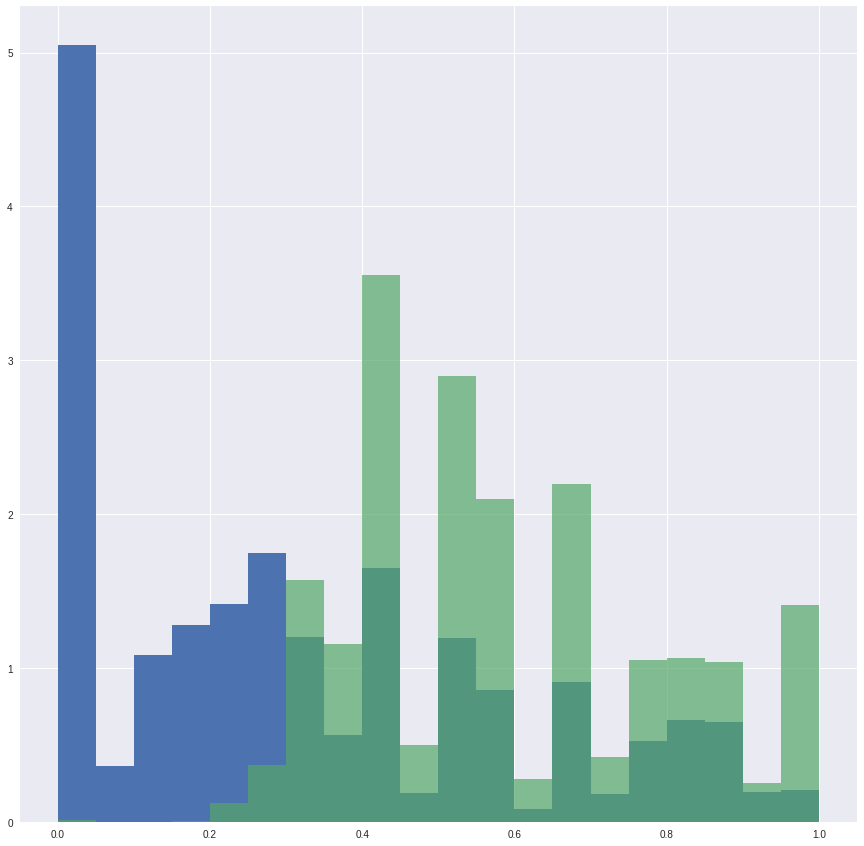

In [28]:
plt.hist(featured_train.z_word_match[featured_train['is_duplicate'] == 0], bins=20, normed=True, label='0')
plt.hist(featured_train.z_word_match[featured_train['is_duplicate'] == 1], bins=20, normed=True, label='1', alpha=0.7)

(array([  1.19359788e+00,   2.67983358e-04,   2.29125771e-02,
          1.33589704e-01,   2.92771819e-01,   5.49231893e-01,
          7.83449348e-01,   1.02959206e+00,   1.30226513e+00,
          1.48610171e+00,   1.54023435e+00,   1.53701855e+00,
          1.48837957e+00,   1.39780120e+00,   1.21101680e+00,
          1.14964861e+00,   9.56432606e-01,   6.06580331e-01,
          2.12912778e-01,   3.10619511e+00]),
 array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
         0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
         0.9 ,  0.95,  1.  ]),
 <a list of 20 Patch objects>)

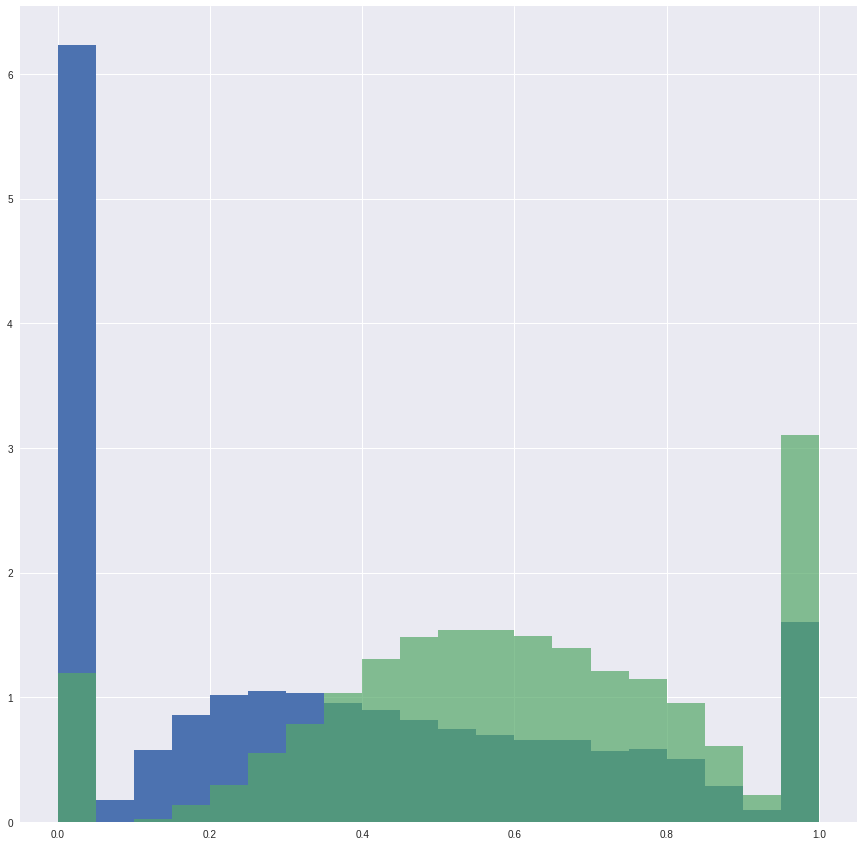

In [29]:
plt.hist(featured_train.z_word_match_idf[featured_train['is_duplicate'] == 0], bins=20, normed=True, label='0')
plt.hist(featured_train.z_word_match_idf[featured_train['is_duplicate'] == 1], bins=20, normed=True, label='1', alpha=0.7)

In [16]:
featured_train['predict'] = bst.predict(xgb.DMatrix(featured_train[col]))

In [17]:
def calc_score(row):
    return log_loss([row['is_duplicate']], [row['predict']], labels=[0, 1])

featured_train['score'] = featured_train.apply(calc_score, axis=1)

In [18]:
#カラム内の文字数。デフォルトは50だった
pd.set_option("display.max_colwidth", 200)

#行数
pd.set_option("display.max_rows", 101)

featured_train[featured_train.is_duplicate == 1].sort_values(by='score', ascending=True)[:1000]#.to_html('hoge.html')

,id,qid1,qid2,question1,question2,is_duplicate,question1_nouns,question2_nouns,z_noun_match,z_len1,...,z_tfidf_sum2,z_tfidf_mean1,z_tfidf_mean2,z_tfidf_len1,z_tfidf_len2,q1_tok_words,q2_tok_words,z_n_sim,predict,score
82791,82791,140312,140313,"I have 86% in 10th, 75% in 12th, my marks in maths in 10th are 84 and in 12th are 57. Does this mean I won't get a call after clearing a MBA entrance?","I have 86% in 10th, 75% in 12th my marks in maths in 10th are 84 and in 12th are 57. Does this mean I won't get a call after clearing a MBA entrance?",1,"[i, %, %, marks, maths, mean, i, call, mba, entrance]","[i, %, %, marks, maths, mean, i, call, mba, entrance]",10,150,...,3.512250,0.250875,0.250875,14,14,"[86, %, 10th, ,, 75, %, 12th, ,, marks, maths, 10th, 84, 12th, 57., mean, wo, n't, get, call, clearing, mba, entrance, ?]","[86, %, 10th, ,, 75, %, 12th, marks, maths, 10th, 84, 12th, 57., mean, wo, n't, get, call, clearing, mba, entrance, ?]",1.000000,0.991085,0.008955
238510,238510,349886,278709,How much refund will I get on my PRS counter ticket if my seat is waitlisted even after the departure of the train? Can I board the train using it,How much refund will I get on my PRS counter ticket if my seat is waitlisted even after the departure of the train? Can I board the train using it?,1,"[refund, prs, counter, ticket, seat, departure, train, board, train]","[refund, prs, counter, ticket, seat, departure, train, board, train]",9,146,...,3.039418,0.303942,0.303942,10,10,"[much, refund, get, prs, counter, ticket, seat, waitlisted, even, departure, train, ?, board, train, using]","[much, refund, get, prs, counter, ticket, seat, waitlisted, even, departure, train, ?, board, train, using, ?]",1.000000,0.988750,0.011314
266127,266127,383251,127962,"A mother is 21 years older than her child. In exactly 6 years from now, the mother will be exactly 5 times as old as the child. Where's the father?",A mother is 21 years older than her child. In exactly 6 years from now the mother will be exactly 5 times as old as the child. Where's the father?,1,"[mother, years, child, years, mother, times, child, father]","[mother, years, child, years, mother, times, child, father]",8,147,...,2.847706,0.316412,0.316412,9,9,"[mother, 21, years, older, child, ., exactly, 6, years, ,, mother, exactly, 5, times, old, child, ., 's, father, ?]","[mother, 21, years, older, child, ., exactly, 6, years, mother, exactly, 5, times, old, child, ., 's, father, ?]",1.000000,0.987838,0.012237
297514,297514,419888,419889,"Can a gas leak kill you by breathing it in? I know it can cause an explosion but can it kill you just by being around it? If it fills up your, house?",Can a gas leak kill you by breathing it in? I know it can cause an explosion but can it kill you just by being around it? If it fills up your house?,1,"[gas, leak, kill, i, explosion, house]","[gas, leak, kill, i, explosion, house]",6,149,...,3.025978,0.302598,0.302598,10,10,"[gas, leak, kill, breathing, ?, know, cause, explosion, kill, around, ?, fills, ,, house, ?]","[gas, leak, kill, breathing, ?, know, cause, explosion, kill, around, ?, fills, house, ?]",1.000000,0.987619,0.012458
286975,286975,401716,103572,Does Congress party digging their grave slowly as they are opposing everything done by PM Modi like saying Jay Shriram or dping surgical strikes?,Does Congress party digging their grave slowly as they are opposing everything done by PM Modi like saying Jay Shriram or doing surgical strikes?,1,"[party, grave, everything, pm, modi, shriram, strikes]","[party, grave, everything, pm, modi, shriram, strikes]",7,145,...,3.846201,0.239028,0.240388,16,16,"[congress, party, digging, grave, slowly, opposing, everything, done, pm, modi, like, saying, jay, shriram, dping, surgical, strikes, ?]","[congress, party, digging, grave, slowly, opposing, everything, done, pm, modi, like, saying, jay, shriram, surgical, strikes, ?]",1.000000,0.987225,0.012857
355686,355686,419889,436917,Can a gas leak kill you by breathi

In [51]:
train[['id', 'z_n_sim']].to_pickle('z_n_sim.pkl')

In [146]:
for column in test.columns:
    test[['test_id', column]].to_pickle('../feature/test_{}.pkl'.format(column))

In [62]:
a = pd.read_pickle('../feature/q1_tok_words.pkl')

In [81]:
print(',\n'.join(map(lambda s: "'{}'".format(s), train.columns)))

'id',
'qid1',
'qid2',
'question1',
'question2',
'is_duplicate',
'question1_nouns',
'question2_nouns',
'z_noun_match',
'z_len1',
'z_len2',
'z_word_len1',
'z_word_len2',
'z_match_ratio',
'z_word_match',
'z_word_match_idf',
'z_tfidf_sum1',
'z_tfidf_sum2',
'z_tfidf_mean1',
'z_tfidf_mean2',
'z_tfidf_len1',
'z_tfidf_len2',
'q1_tok_words',
'q2_tok_words',
'z_n_sim'


In [83]:
features = [
    'question1_nouns',
    'question2_nouns',
    'z_noun_match',
    'z_len1',
    'z_len2',
    'z_word_len1',
    'z_word_len2',
    'z_match_ratio',
    'z_word_match',
    'z_word_match_idf',
    'z_tfidf_sum1',
    'z_tfidf_sum2',
    'z_tfidf_mean1',
    'z_tfidf_mean2',
    'z_tfidf_len1',
    'z_tfidf_len2',
    'q1_tok_words',
    'q2_tok_words',
    'z_n_sim'
]

In [145]:
test[:10]

,test_id,question1,question2,question1_nouns,question2_nouns,z_noun_match,z_len1,z_len2,z_word_len1,z_word_len2,...,z_word_match_idf,z_tfidf_sum1,z_tfidf_sum2,z_tfidf_mean1,z_tfidf_mean2,z_tfidf_len1,z_tfidf_len2,q1_tok_words,q2_tok_words,z_n_sim
0,0,How does the Surface Pro himself 4 compare with iPad Pro?,Why did Microsoft choose core m3 and not core i3 home Surface Pro 4?,"[surface, compare]","[core, m3, i3, home, surface]",1,57,68,11,14,...,0.331219,2.048751,2.831757,0.409750,0.314640,5,9,"[surface, pro, 4, compare, ipad, pro, ?]","[microsoft, choose, core, m3, core, i3, home, surface, pro, 4, ?]",0.604355
1,1,Should I have a hair transplant at age 24? How much would it cost?,How much cost does hair transplant require?,"[hair, transplant, age]","[cost, require]",0,66,43,14,7,...,0.705248,2.209699,2.151824,0.441940,0.430365,5,5,"[hair, transplant, age, 24, ?, much, would, cost, ?]","[much, cost, hair, transplant, require, ?]",0.891097
2,2,What but is the best way to send money from China to the US?,What you send money to China?,"[way, money, china]",[money],1,60,29,14,6,...,0.626224,2.174504,1.715722,0.434901,0.571907,5,3,"[best, way, send, money, china, us, ?]","[send, money, china, ?]",0.836399
3,3,Which food not emulsifiers?,What foods fibre?,"[food, emulsifiers]",[fibre],0,27,17,4,3,...,0.000000,1.337203,1.399856,0.668602,0.699928,2,2,"[food, emulsifiers, ?]","[foods, fibre, ?]",0.680346
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?,"[aberystwyth, start, reading]",[reading],1,32,30,4,6,...,1.000000,1.620889,1.399301,0.540296,0.699651,3,2,"[``, aberystwyth, '', start, reading, ?]","[start, reading, ?]",1.000000
5,5,How are the two wheeler insurance from Bharti Axa insurance?,I admire I am considering of buying insurance from them,"[wheeler, insurance, bharti, axa, insurance]","[i, i, insurance]",2,60,55,10,10,...,0.202131,1.972337,1.988617,0.493084,0.497154,4,4,"[two, wheeler, insurance, bharti, axa, insurance, ?]","[admire, considering, buying, insurance]",0.548981
6,6,How can I reduce my belly fat through a diet?,How can I reduce my lower belly fat in one month?,"[belly, diet]",[month],0,45,49,10,11,...,0.836152,1.997432,2.229369,0.499358,0.445874,4,5,"[reduce, belly, fat, diet, ?]","[reduce, lower, belly, fat, one, month, ?]",0.781006
7,7,"By scrapping the 500 and 1000 rupee notes, how is RBI planning to fight against issue black money?",How will the recent move to declare 500 and 1000 denomination lewin illegal will curb black money?,"[rupee, notes, issue, money]","[move, denomination, illegal, money]",1,98,98,18,17,...,0.267338,3.276648,3.065858,0.297877,0.306586,11,10,"[scrapping, 500, 1000, rupee, notes, ,, rbi, planning, fight, issue, black, money, ?]","[recent, move, declare, 500, 1000, denomination, lewin, illegal, curb, black, money, ?]",0.546812
8,8,What are the how best books of all time?,What are some of the military history books of all time?,"[books, time]","[history, books, time]",2,40,56,9,11,...,0.395101,1.697861,1.973717,0.565954,0.493429,3,4,"[best, books, time, ?]","[military, history, books, time, ?]",0.721729
9,9,"After 12th years old boy and I had sex with a 12 years old girl, with her consent. Is there anything wrong?",Can a 14 old guy date a 12 year old girl?,"[years, boy, i, sex, years, girl, consent, anything]","[guy, date, year, girl]",1,107,41,22,11,...,0.325677,2.896102,2.558221,0.321789,0.365460,9,7,"[12th, years, old, boy, sex, 12, years, old, girl, ,, consent, ., anything, wrong, ?]","[14, old, guy, date, 12, year, old, girl, ?]",0.805124


In [113]:
a = pd.read_pickle('../feature/z_len1.pkl')

FileNotFoundError: [Errno 2] No such file or directory: '../feature/z_len1.pkl'

In [116]:
rest = pd.read_csv('../input/train.csv')

In [117]:
for feature in features:
    rest = pd.merge(rest, pd.read_pickle('../feature/train_{}.pkl'.format(feature)))

In [121]:
for feature in []:
    if not all(rest[feature] == featured_train[feature]):
        print(feature)

z_tfidf_mean1
z_tfidf_mean2


In [131]:
f = rest['z_tfidf_mean1'] != featured_train['z_tfidf_mean1']

In [140]:
len(rest.z_tfidf_mean1[np.isnan(rest.z_tfidf_mean1)])

254

In [147]:
len(featured_train.z_tfidf_mean1[np.isnan(rest.z_tfidf_mean1)])

254

In [ ]:
test = pd.read_csv('../input/test.csv')
for feature in features:
    test = pd.merge(test, pd.read_pickle('../feature/test_{}.pkl'.format(feature)))

In [149]:
features = [
    'question1_nouns',
    'question2_nouns',
    'z_noun_match',
    'z_len1',
    'z_len2',
    'z_word_len1',
    'z_word_len2',
    'z_match_ratio',
    'z_word_match',
    'z_word_match_idf',
    'z_tfidf_sum1',
    'z_tfidf_sum2',
    'z_tfidf_mean1',
    'z_tfidf_mean2',
    'z_tfidf_len1',
    'z_tfidf_len2',
    'q1_tok_words',
    'q2_tok_words',
    'z_n_sim'
]